# Modeling Rare Events with Fraud Detection and Random Oversampling

In [1]:
# Import dependencies
import dask
import dask.dataframe as ddf
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error, accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
from imblearn.over_sampling import RandomOverSampler


## Utility Functions

In [2]:
def get_elasticnet(X, y, column_names, max_iter=10000):
    """
    Select significant variables according to Elastic Net.
    @param X <Pandas Dataframe>
    @param y <list>
    @columns <list>
    @max_iter <int>
    @returns <list>
    """ 
    def get_mse(alpha):
        model = ElasticNet(alpha=a, max_iter=max_iter).fit(X, y)   
        score = model.score(X, y)
        pred_y = model.predict(X)
        return mean_squared_error(y, pred_y)
        
    lowest_mse = 1.0
    best_alpha = 0.0
    alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
    
    for a in alphas:
        mse = get_mse(a)
        if mse < lowest_mse:
            lowest_mse = mse
            best_alpha = a
        
    clf = ElasticNet(alpha=best_alpha, max_iter=max_iter)
    sfm = SelectFromModel(clf)
    sfm.fit(X, y)
    feature_indices = sfm.get_support()
    significant_features = []
    for c, b in zip(column_names, feature_indices):
        if b:
            significant_features.append(c)

    return significant_features

def get_balanced_accuracy(tpr, fpr):
    """
    Return average of Sensitivity and Specificity.
    """
    return (tpr + (1-fpr)) / 2

def get_tpr_fpr(cm):
    """
    Sensitivity: TruePos / (True Pos + False Neg) 
    Specificity: True Neg / (False Pos + True Neg)
    TN | FP
    -------
    FN | TP
    @param 2D array <list<list>>
    @returns <list<float>>
    """
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])

    tpr = tp / (tp + fn)
    fpr = 1-(tn / (fp + tn))

    return [tpr, fpr]

def get_best_cutoff(actual, prob):  
    """
    Get the best cutoff according to Balanced Accuracy
    'Brute-force' technique - try all cutoffs from 0.01 to 0.99 in increments of 0.01

    @param actual <list<float>>
    @param prob <list<tuple<float, float>>>
    @returns <list<float>>
    """
    best_tpr = 0.0; best_fpr = 0.0; best_cutoff = 0.0; best_ba = 0.0; 
    cutoff = 0.0
    cm = [[0,0],[0,0]]
    while cutoff < 1.0:
        pred = list(map(lambda p: 1 if p >= cutoff else 0, prob))
        _cm = confusion_matrix(actual, pred)
        _tpr, _fpr = get_tpr_fpr(_cm)

        if(_tpr < 1.0):    
            ba = get_balanced_accuracy(tpr=_tpr, fpr=_fpr)

            if(ba > best_ba):
                best_ba = ba
                best_cutoff = cutoff
                best_tpr = _tpr
                best_fpr = _fpr
                cm = _cm

        cutoff += 0.01

    tn = cm[0][0]; fp = cm[0][1]; fn = cm[1][0]; tp = cm[1][1];
    return [best_tpr, best_fpr, best_cutoff, tn, fp, fn, tp]
    
# create confusion matrix
def get_predict_frame(actual, prob, model_name='Logit'):
    """
    Compute predicted based on estimated probabilities and best threshold. 
    Output predictions and confusion matrix.
    """
    # calculate TPR, FPR, best probability threshold
    tpr, fpr, cutoff, tn, fp, fn, tp = get_best_cutoff(actual, prob)
    accuracy = get_balanced_accuracy(tpr, fpr)
    auc = roc_auc_score(actual, prob)
    
    #print("Optimal prob. threshold is %0.3f: " % cutoff)
    yhat = list(map(lambda p: 1 if p >= cutoff else 0, prob))
    stats = pd.DataFrame(columns=['Model', 'TP', 'FP', 'TN', 'FN', 'Sensitivity', 'Specificity', 'Cutoff', 'Accuracy', 'AUC'],
                data=[[model_name, tp, fp, tn, fn, tpr, (1-fpr), cutoff, accuracy, auc]])

    print("Sensitivity: {0:.3f}%, Specificity: {1:.3f}%, Threshold: {2:.3f}".format(tpr*100, (1-fpr)*100, cutoff))
    return yhat, stats

def plot_roc(actual, prob):
    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(actual, prob)

    # plot ROC curve
    fig = plt.figure(figsize=(10, 10))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.show()

## Sample

In [3]:
# Import XDF data file and describe data.
df = ddf.read_csv('creditcard.csv').compute()
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.762597e-12,-8.251146e-13,-9.655448e-13,8.321385e-13,1.649983e-13,4.248434e-13,-3.054696e-13,8.777981e-14,-1.179757e-12,...,-3.405785e-13,-5.723165e-13,-9.725860e-13,1.464148e-12,-6.987110e-13,-5.617884e-13,3.332082e-12,-3.518875e-12,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Explore

In [4]:
# Check for missing data
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
# Check for rows with nulls
df[df.isnull().any(axis=1)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


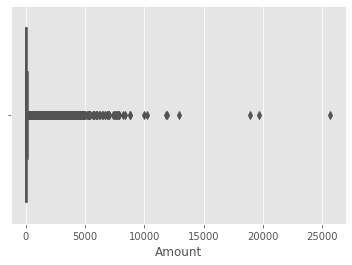

In [6]:
box_amount = sb.boxplot(x=df.Amount)

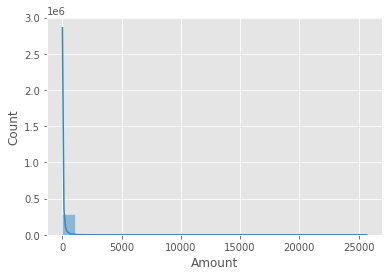

In [7]:
hist_amount = sb.histplot(df.Amount, bins=25, kde=True)

In [8]:
TARGET = 'Class' # The name of our target variable.

In [9]:
# Is this a rare event problem where the minority class < 2%.
fraud = df.query(TARGET + ' == 1')
nonfraud = df.query(TARGET + ' == 0')
ratio = len(fraud) / len(df)*100
print(str.format("The ratio of fraud to non-fraud transactions is {0:.3f}% to {1:.3f}%.", ratio, 100-ratio))

The ratio of fraud to non-fraud transactions is 0.173% to 99.827%.


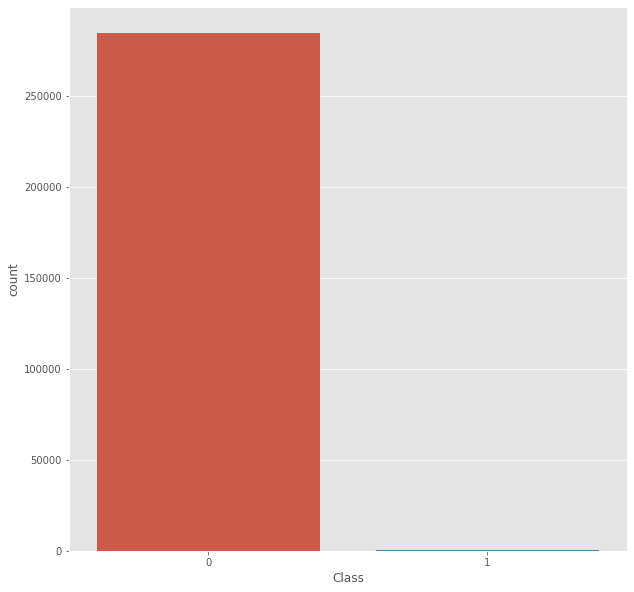

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
fraud_cats = sb.countplot(x=TARGET, data=df)

## Modify &ndash; Oversample the minority class

In [11]:
features = df.drop(['Time', 'Class'], 1)
target = df['Class']
column_names = features.columns

x_train, x_val, y_train, y_val = train_test_split(features.values, target.values, test_size=0.1, random_state=123)
 
# Oversample minority class
ros = RandomOverSampler(sampling_strategy='minority', random_state=123)
X_over, y_over = ros.fit_resample(x_train, y_train)

In [12]:
df_val = pd.DataFrame(columns=column_names, data=x_val)
df_val[TARGET] = y_val

In [13]:
# Is this a rare event problem where the minority class < 2%.
fraud = [y for y in y_over if y == 1]
nonfraud = [y for y in y_over if y == 0]
ratio = len(fraud) / len(df)*100
print(str.format("The ratio of fraud to non-fraud transactions is {0:.3f}% to {1:.3f}%.", ratio, 100-ratio))

The ratio of fraud to non-fraud transactions is 89.845% to 10.155%.


In [14]:
df_over = pd.DataFrame(columns=column_names, data=X_over)
df_over[TARGET] = y_over
df_over[TARGET].describe()

count    511770.0
mean          0.5
std           0.5
min           0.0
25%           0.0
50%           0.5
75%           1.0
max           1.0
Name: Class, dtype: float64

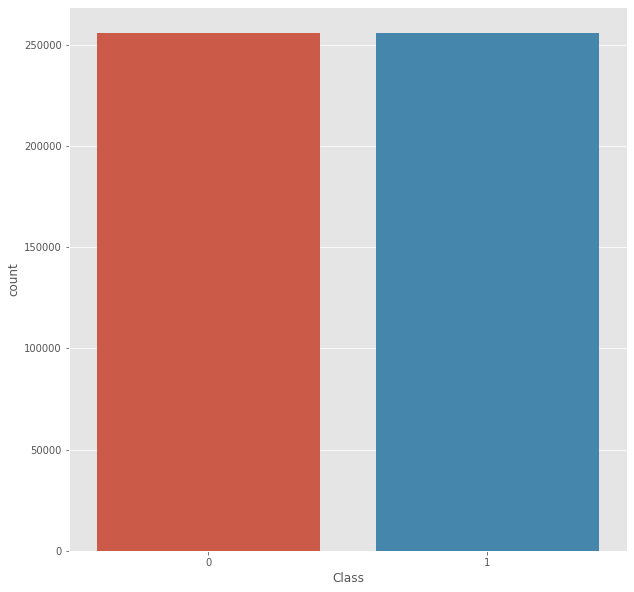

In [15]:
f, ax = plt.subplots(figsize=(10, 10))
fraud_cats = sb.countplot(x=TARGET, data=df_over)

## Model

### Feature Selection

In [16]:
# ElasticNet feature selection for significant predictors
sig_features = get_elasticnet(X_over, y_over, column_names)
sig_features

['V1', 'V4', 'V7', 'V13', 'V14', 'V18', 'V22', 'V23', 'V26', 'V28']

### Select Significant Features

In [17]:
x_train = df_over[sig_features].values
y_train = df_over[TARGET].values

df_val = df_val[sig_features]
df_val[TARGET] = y_val

x_val = df_val[sig_features].values
y_val = df_val[TARGET].values

In [18]:
# Create formula string
formula = TARGET + " ~ " + " + ".join(sig_features)
formula

'Class ~ V1 + V4 + V7 + V13 + V14 + V18 + V22 + V23 + V26 + V28'

### StatsModels Logit

In [19]:
sm_logit = smf.logit(formula=formula, data=df_over).fit()
sm_logit.summary2()

Optimization terminated successfully.
         Current function value: 0.174905
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.748      
Dependent Variable: Class            AIC:              179044.7468
Date:               2021-03-05 10:20 BIC:              179167.3487
No. Observations:   511770           Log-Likelihood:   -89511.    
Df Model:           10               LL-Null:          -3.5473e+05
Df Residuals:       511759           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept    -2.8786    0.0093  -309.2938  0.0000  -2.8968  -2.8603
V1           -0.1401    0.0031   -45.0265  0.0000  -0.1462  -0.1340
V4            0.8153    0.0044   186.8207  0.0000   0.8067   0.8238
V7            0.0238    0.0038     6.2320  0.0000   0.0163   0.0313
V13          -0.3602    0.0063   -56.9675  0.0000  -0.3726  -0.3478
V14          -1.0422    0.0048  -215.6022  0.0000  -1.0517  -1.0328
V18          -0.0880    0.0068   -12.8820  0.0000  -0.1014  -0.0746
V22           0.3040    0.0082    37.1844  0.0000   0.2880   0.3201
V23          -0.2957    0.0052   -56.7255  0.0000  -0.3059  -0.2854
V26          -0.4135    0.0134   -30.8966  0.0000  -0.4397  -0.3873
V28           0.2985    0.0194    15.4081  0.0000   0.2605   0.3365
==================================================================

"""

Sensitivity: 87.846%, Specificity: 98.010%, Threshold: 0.580
Sensitivity: 94.118%, Specificity: 98.755%, Threshold: 0.740


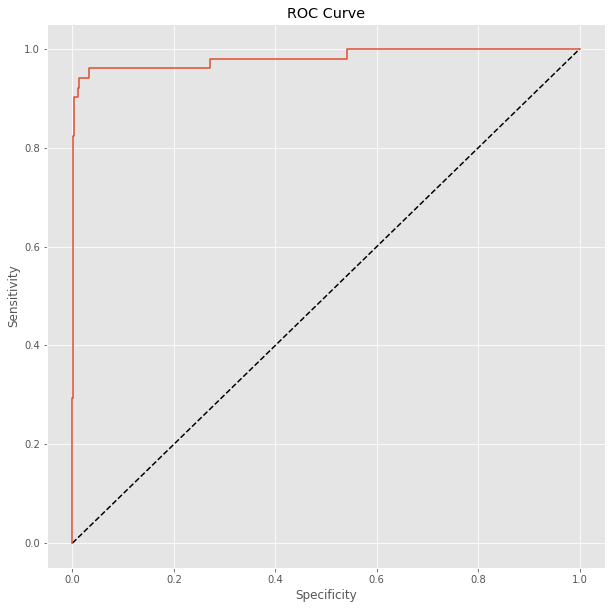

          Model  TP   FP     TN  FN  Sensitivity  Specificity  Cutoff  \
0  SM Logit Val  48  354  28076   3     0.941176     0.987548    0.74   

   Accuracy       AUC  
0  0.964362  0.982407  
            Model      TP    FP      TN     FN  Sensitivity  Specificity  \
0  SM Logit Train  224785  5091  250794  31100     0.878461     0.980104   

   Cutoff  Accuracy       AUC  
0    0.58  0.929283  0.979213  


In [20]:
df_val['prob'] = sm_logit.predict(df_val)
yhat_train, stats_train = get_predict_frame(y_train, sm_logit.fittedvalues, 'SM Logit Train')
yhat, stats = get_predict_frame(y_val, df_val.prob, 'SM Logit Val')
df_val['yhat'] = yhat
plot_roc(y_val, df_val.prob)
print(stats.head())
print(stats_train.head())

### Scikit Logit

Sensitivity: 94.118%, Specificity: 98.755%, Threshold: 0.740
Sensitivity: 87.846%, Specificity: 98.000%, Threshold: 0.640


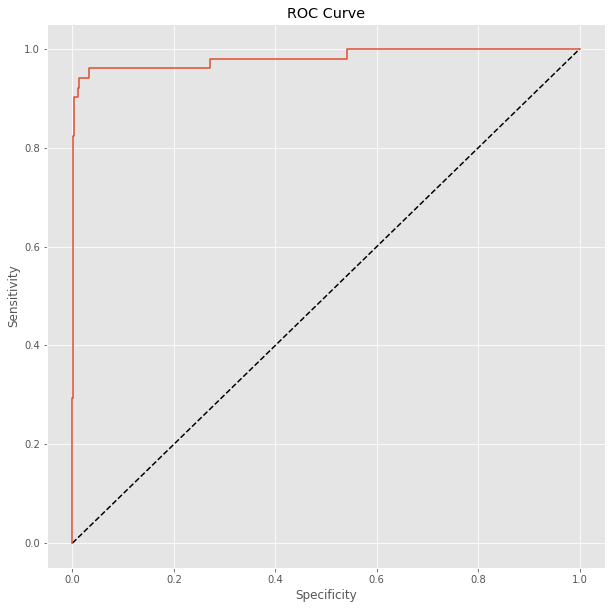

              Model  TP   FP     TN  FN  Sensitivity  Specificity  Cutoff  \
0  Scikit Logit Val  48  354  28076   3     0.941176     0.987548    0.74   

   Accuracy       AUC  
0  0.964362  0.982408  
                Model      TP    FP      TN     FN  Sensitivity  Specificity  \
0  Scikit Logit Train  224785  5117  250768  31100     0.878461     0.980003   

   Cutoff  Accuracy       AUC  
0    0.64  0.929232  0.979213  


In [21]:
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
logit_model = LogisticRegression(C=1/reg, max_iter=10000, solver='liblinear').fit(x_train, y_train)

logit_predictions = logit_model.predict(x_val)
logit_y_scores = logit_model.predict_proba(x_val)
logit_y_scores_train = logit_model.predict_proba(x_train)

logit_prob = logit_y_scores[:,1]
logit_prob_train = logit_y_scores_train[:,1]
logit_yhat, logit_stats = get_predict_frame(y_val, logit_prob, 'Scikit Logit Val')
logit_yhat_train, logit_stats_train = get_predict_frame(y_train, logit_prob_train, 'Scikit Logit Train')
plot_roc(y_val, logit_prob)
print(logit_stats.head())
print(logit_stats_train.head())

### Scikit Decision Tree

Sensitivity: 76.471%, Specificity: 99.965%, Threshold: 0.010
Sensitivity: 0.000%, Specificity: 100.000%, Threshold: 0.000


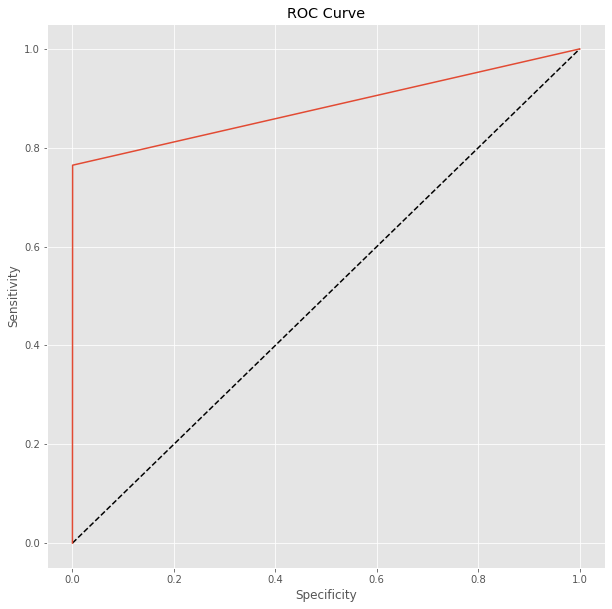

              Model  TP  FP     TN  FN  Sensitivity  Specificity  Cutoff  \
0  Scikit DTree Val  39  10  28420  12     0.764706     0.999648    0.01   

   Accuracy       AUC  
0  0.882177  0.882177  
                Model  TP  FP  TN  FN  Sensitivity  Specificity  Cutoff  \
0  Scikit DTree Train   0   0   0   0          0.0          1.0     0.0   

   Accuracy  AUC  
0       0.5  1.0  


In [22]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier().fit(x_train, y_train)
tree_predictions = tree_model.predict(x_val)
tree_y_scores = tree_model.predict_proba(x_val)
tree_y_scores_train = tree_model.predict_proba(x_train)
tree_prob = tree_y_scores[:,1]
tree_prob_train = tree_y_scores_train[:,1]

tree_yhat, tree_stats = get_predict_frame(y_val, tree_prob, 'Scikit DTree Val')
tree_yhat_train, tree_stats_train = get_predict_frame(y_train, tree_prob_train, 'Scikit DTree Train')

plot_roc(y_val, tree_prob)
print(tree_stats.head())
print(tree_stats_train.head())

### Scikit Random Forest

Sensitivity: 94.118%, Specificity: 99.082%, Threshold: 0.020
Sensitivity: 94.118%, Specificity: 99.082%, Threshold: 0.020


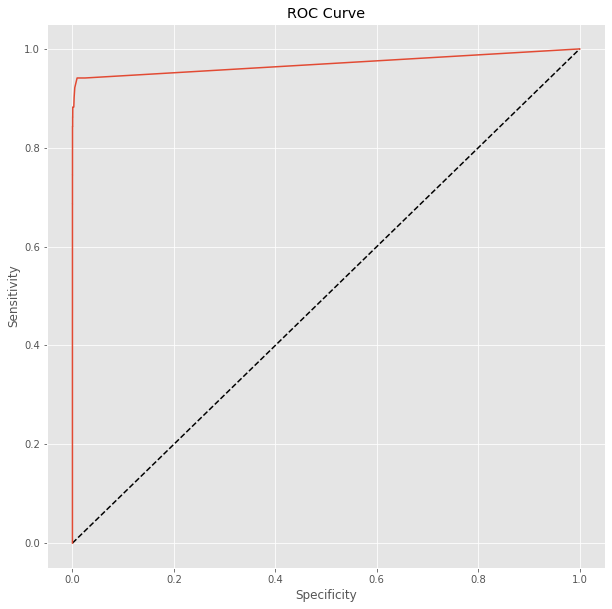

               Model  TP   FP     TN  FN  Sensitivity  Specificity  Cutoff  \
0  Scikit Forest Val  48  261  28169   3     0.941176      0.99082    0.02   

   Accuracy       AUC  
0  0.965998  0.969539  
                 Model  TP   FP     TN  FN  Sensitivity  Specificity  Cutoff  \
0  Scikit Forest Train  48  261  28169   3     0.941176      0.99082    0.02   

   Accuracy       AUC  
0  0.965998  0.969539  


In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=100).fit(x_train, y_train)
forest_predictions = forest_model.predict(x_val)
forest_y_scores = forest_model.predict_proba(x_val)
forest_y_scores_train = forest_model.predict_proba(x_train)
forest_prob = forest_y_scores[:,1]
forest_prob_train = forest_y_scores_train[:,1]

forest_yhat, forest_stats = get_predict_frame(y_val, forest_prob, 'Scikit Forest Val')
forest_yhat_train, forest_stats_train = get_predict_frame(y_val, forest_prob, 'Scikit Forest Train')
plot_roc(y_val, forest_prob)
print(forest_stats.head())
print(forest_stats_train.head())

## Assess

In [27]:
compare = pd.concat([stats, stats_train, logit_stats, logit_stats_train, tree_stats, forest_stats, forest_stats_train], 0)
compare.sort_values('Accuracy')
compare.head(10)

,Model,TP,FP,TN,FN,Sensitivity,Specificity,Cutoff,Accuracy,AUC
0,SM Logit Val,48,354,28076,3,0.941176,0.987548,0.74,0.964362,0.982407
0,SM Logit Train,224785,5091,250794,31100,0.878461,0.980104,0.58,0.929283,0.979213
0,Scikit Logit Val,48,354,28076,3,0.941176,0.987548,0.74,0.964362,0.982408
0,Scikit Logit Train,224785,5117,250768,31100,0.878461,0.980003,0.64,0.929232,0.979213
0,Scikit DTree Val,39,10,28420,12,0.764706,0.999648,0.01,0.882177,0.882177
0,Scikit Forest Val,48,261,28169,3,0.941176,0.990820,0.02,0.965998,0.969539
0,Scikit Forest Train,48,261,28169,3,0.941176,0.990820,0.02,0.965998,0.969539


In [ ]:
df_val['prob'] = prob
df_val['yhat'] = yhat
df_val.to_csv('validation.csv')